# Data Scraping and Analysis of Walmart Product Reviews

### Project Name : "Review Preview"
### Team: Group 9
•	Abhilash Gadepalli (PGID:12010078)
Email : abhilash_gadepalli_ampba2021s@isb.edu

•	Chandra Shekhar Bhakat (PGID:1201005
Email: ChandraShekhar_Bhakat_AMPBA2021S@isb.edu

•	Kristi Haldar (PGID:12010077)
Email: Kristi_haldar_ampba2021s@isb.edu

•	Monica Nayagam (PGID:12010016)
Email: MonicaRonald_Nayagam_ampbas@isb.edu

•	Tejasvi Narreddy (PGID:12010035)
Email: Tejasvi_Narreddy_AMPBA2021S@isb.edu


#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Overview :
Code will scrape reviews from walmart.com for different products and clean it for machine learning model. This code will also help to identify sentiment intensity of each review and the gist of key factors involved from all reviews for a 
perticular product.

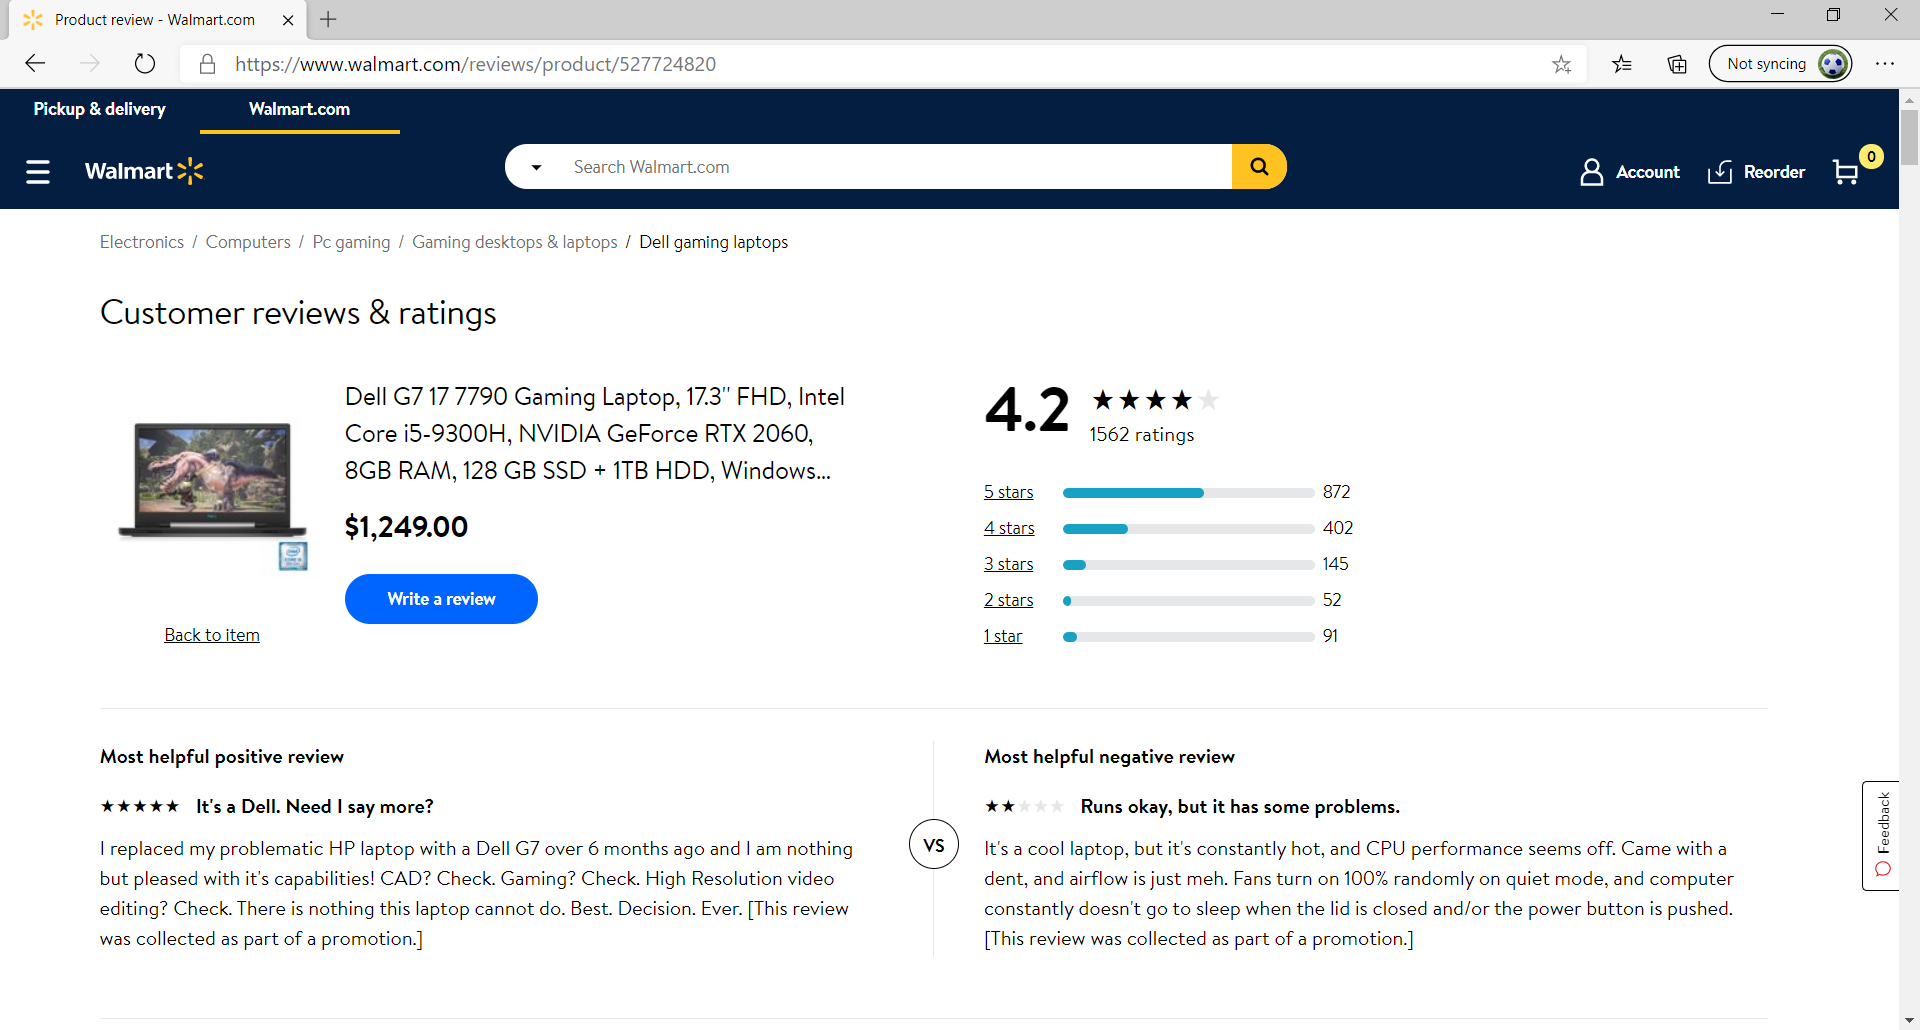

### Installation 
Skip in case you have already installed 

In [18]:
#The following libraries are required for successful execution of this code.
!pip install nltk
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install wordcloud
!pip install pandas
!conda install seaborn
!pip install lxml

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


Solving environment: ...working... done

# All requested packages already installed.



Import all necessary libraries 

In [19]:
import sys
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import csv
import math
import os
import time
import seaborn as sb
import nltk
nltk.download('vader_lexicon')
import en_core_web_sm
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Monica\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
#Create variables for different files and products
global raw_csv_file 
raw_csv_file = os.getcwd()+"\\product_reviews.csv"

global processed_csv_file 
processed_csv_file = os.getcwd()+"\\processed_product_reviews.csv"

global temp_csv_file 
temp_csv_file = os.getcwd()+"\\temp_product_reviews.csv"

global products 
#products = TV, Gaming Laptop, Google Home Device, Security Camera, Kitchen Aid Beater
products = ["632565655","527724820","54742302","835969619","15436023"]

In [21]:
#Look for the url and make a BeautifulSoup Object
def get_request(url):
    
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "lxml")
        if response.status_code == 200:
            return soup
        else:
            sys.exit(response.status_code)
    
    except Exception as e:
        print("Cannot get request")
        sys.exit(e)

In [22]:
#Get user reviews
def get_reviews(soup):
    try:
        return(soup.p.text.replace("[This review was collected as part of a promotion.]",""))
    except Exception as e:
        #Return None if there is no user review
        return "None"

In [23]:
#Extract the sub tag required for reviews
def get_semi_soup(soup):
    try:
        return(soup.find_all("div", {"class":"Grid ReviewList-content"}))
    except Exception as e:
        sys.exit(e)

In [24]:
#Get individual user ratings
def get_user_rating(soup):
    return (soup.find("span", {"class":"visuallyhidden seo-avg-rating"}).string)

In [25]:
# Get dates of each reviews 
def get_review_dates(soup):
    date = soup.find('span',{'class':'review-footer-submissionTime'}).string
    return date

In [26]:
# Get all customer nick names corresponding to reviews 
def get_user_names(soup):
    user=soup.find('span',{'class':'review-footer-userNickname'}).string
    return user

In [27]:
#Get total number of ratings. Use this to determine total number of pages to scrape.
def get_rating_count(soup):
    return(soup.find('div',{'class':'product-review-stars-container-ratings-row'}).string.replace("ratings",""))

In [28]:
def clean_up_dataset():
    try:
        c_df = pd.read_csv(raw_csv_file)
    
        c_df['User Reviews'].replace('None', np.nan, inplace=True)
        c_df=c_df.dropna()
        c_df.to_csv(temp_csv_file, index=False)
    
    except Exception as e: 
        sys.exit("********ERROR : Cannot find/open product_reviews.csv file ")

In [29]:
# Word count dictionary. This function is only for verification and not used in the code. 
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [30]:
#Create a wordcloud visualization of the keywords/aspects found in the reviews.
def create_wordcloud(p_df):
    words = ""
    #Use Lemmas field from the data set
    for l in p_df['Lemmas']:
        words = str(l) + "" + str(words)
        
    # Create and generate a word cloud image
    wordcloud = WordCloud().generate(words)

    # Display the generated image:
    plt.figure(figsize=(30,30))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Storing reviews in "product_reviews.csv" file. 
The CSV file can be found in the current working directory or run os.getcwd() command to get it .


In [32]:
#Here we do pagination --> go to every page to get reviews and other details

prod_dict = {}

#Create a csv file. 
try:
    csv_file = open(raw_csv_file, 'w', encoding="UTF-8", newline="")
    writer = csv.writer(csv_file)
except Exception as e:
     sys.exit(str(e))

start = time.time()

print("********GET REVIEWS START********")
#Create the column names in csv file
writer.writerow(['Product id','User','Date','User Rating','User Reviews'])
for p in products:
    print ("Getting reviews from Walmart for product id : " + str(p))
    #Get total number of ratings to calculate the number of pages to scrape for information
    url_page = "https://www.walmart.com/reviews/product/"+str(p)
    soup = get_request(url_page)

    #Number of pages
    page_count = math.ceil(int(get_rating_count(soup))/20)
    page = 1

    #Iterate the pages to get info
    while page <= page_count:

        #Create the page url
        url_page = "https://www.walmart.com/reviews/product/"+str(p)+"?page="+str(page)
        soup = get_request(url_page)
        #Get the outermost tag for reviews 
        review_soup = get_semi_soup(soup)

        #Iterate over the outermost tage to get information for the review 
  
        for reviews in review_soup:

            #User name
            user = get_user_names(reviews)

            #User rating
            user_rating = get_user_rating(reviews)

            #Date of review
            review_date = get_review_dates(reviews)

            #Review 
            review = get_reviews(reviews)

            prod_dict['Product id'] = str(p)
            prod_dict['User'] = user
            prod_dict['Date'] = review_date
            prod_dict['User Rating'] = user_rating
            prod_dict['User Reviews'] = review

            #Write to csv file
            writer.writerow(prod_dict.values())
        page = page+1
print("********GET REVIEWS DONE********")    
csv_file.close() 
print('Time taken to scrape reviews and write to CSV file : {} mins'.format(round((time.time() - start) / 60, 2)))

********GET REVIEWS START********
Getting reviews from Walmart for product id : 632565655
Getting reviews from Walmart for product id : 527724820
Getting reviews from Walmart for product id : 54742302
Getting reviews from Walmart for product id : 835969619
Getting reviews from Walmart for product id : 15436023
********GET REVIEWS DONE********
Time taken to scrape reviews and write to CSV file : 5.98 mins


In [42]:
#Print the raw dataframe created after scrapping data from walmart 
raw_p_df = pd.read_csv(raw_csv_file)
raw_p_df

Product id                 User               Date  User Rating  \
0      632565655              Raven,      March 31, 2020          5.0   
1      632565655                  NaN     April 30, 2020          5.0   
2      632565655            Chrissy,       July 11, 2020          5.0   
3      632565655              Jodie,       July 22, 2020          5.0   
4      632565655            JPinTex,   December 21, 2019          5.0   
...          ...                  ...                ...          ...   
3655    15436023               BMW1,      March 12, 2019          1.0   
3656    15436023  Sweet lady sophia,       July 18, 2019          1.0   
3657    15436023              Gidon,    December 6, 2018          1.0   
3658    15436023           Michelle,        June 4, 2016          3.0   
3659    15436023        Happy Baker,     August 21, 2016          4.0   

                                           User Reviews  
0     No complaints so far (I've had it for about 2-...  
1     It's easy to get around the apps the download ...  
2     I purchased an Element 50 inch television in 2...  
3     Absolutely beautiful color! Setup was fast and...  
4     Only had this a few weeks but it has been grea...  
...                                                 ...  
3655  just like all of the other reviews, beater pai...  
3656  Paint chipping off.  Poor quality.  I've been ...  
3657  Really disappointed of the poor quality of thi...  
3658  I would agree with the others. The coating is ...  
3659  I have the KSM450ER and need the part number f...  

[3660 rows x 5 columns]

In [43]:
clean_up_dataset()

### Data Cleaning and Sentiment Intensity Analysis
Using  SentimentIntensityAnalyzer class from nltk.sentiment package

In [44]:
#Load the csv and create DataFrame
try:

    p_df = pd.read_csv(temp_csv_file)
       
except Exception as e: 
    sys.exit("********ERROR : Cannot find/open product_reviews.csv file ")

#Use NLP to generate Lemmas (keywords/aspects) for each user review
print("Generating Lemmas and Sentiment Intensity for reviews")
p_df["Lemmas"] = [" ".join([token.lemma_ if token.lemma_ != "-PRON-" else token.lower() for sentence in nlp(speech).sents for token in sentence if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV", "X"} and token.is_stop == False]) for speech in p_df['User Reviews']]

sia = SentimentIntensityAnalyzer()
sentiment_score=[]
for i in range(len(p_df)):
    ss = sia.polarity_scores(p_df.Lemmas[i])
    sentiment_score.append(ss)
    
compound=[sentiment_score[i]['compound'] for i in range(len(sentiment_score))]
p_df['SIntensity']=compound

#Write Lemmas and sentiment intensity to csv file
try:
    p_df.to_csv(processed_csv_file, index=False)
    os.remove(temp_csv_file)
    print("Processed data file generated.")
except Exception as e:
    sys.exit("********ERROR********")


Generating Lemmas and Sentiment Intensity for reviews
Processed data file generated.


In [45]:
#Print the processed dataframe created after cleanup and processing
processed_p_df = pd.read_csv(processed_csv_file)
processed_p_df

Product id                 User               Date  User Rating  \
0      632565655              Raven,      March 31, 2020          5.0   
1      632565655            Chrissy,       July 11, 2020          5.0   
2      632565655              Jodie,       July 22, 2020          5.0   
3      632565655            JPinTex,   December 21, 2019          5.0   
4      632565655           Lawrence,       March 8, 2020          5.0   
...          ...                  ...                ...          ...   
2141    15436023               BMW1,      March 12, 2019          1.0   
2142    15436023  Sweet lady sophia,       July 18, 2019          1.0   
2143    15436023              Gidon,    December 6, 2018          1.0   
2144    15436023           Michelle,        June 4, 2016          3.0   
2145    15436023        Happy Baker,     August 21, 2016          4.0   

                                           User Reviews  \
0     No complaints so far (I've had it for about 2-...   
1     I purchased an Element 50 inch television in 2...   
2     Absolutely beautiful color! Setup was fast and...   
3     Only had this a few weeks but it has been grea...   
4     TV arrived when it wa supposed to, in undamage...   
...                                                 ...   
2141  just like all of the other reviews, beater pai...   
2142  Paint chipping off.  Poor quality.  I've been ...   
2143  Really disappointed of the poor quality of thi...   
2144  I would agree with the others. The coating is ...   
2145  I have the KSM450ER and need the part number f...   

                                                 Lemmas  SIntensity  
0     complaint far week great sound quality great p...      0.9595  
1     purchase inch television love picture quality ...      0.7430  
2     absolutely beautiful color setup fast easy wor...      0.9402  
3     week great good bright picture awesome color g...      0.9578  
4     tv arrive wa suppose undamaged original packag...      0.8807  
...                                                 ...         ...  
2141  review beater paint chip multiple place see re...      0.0000  
2142  paint chip poor quality flat beater rubber pie...     -0.4767  
2143  disappointed poor quality product coating peel...     -0.2023  
2144  agree coating come beater vet disappointed rev...     -0.1531  
2145  ksm450er need number beater scraper white coat...      0.0772  

[2146 rows x 7 columns]

### Creating Word Cloud

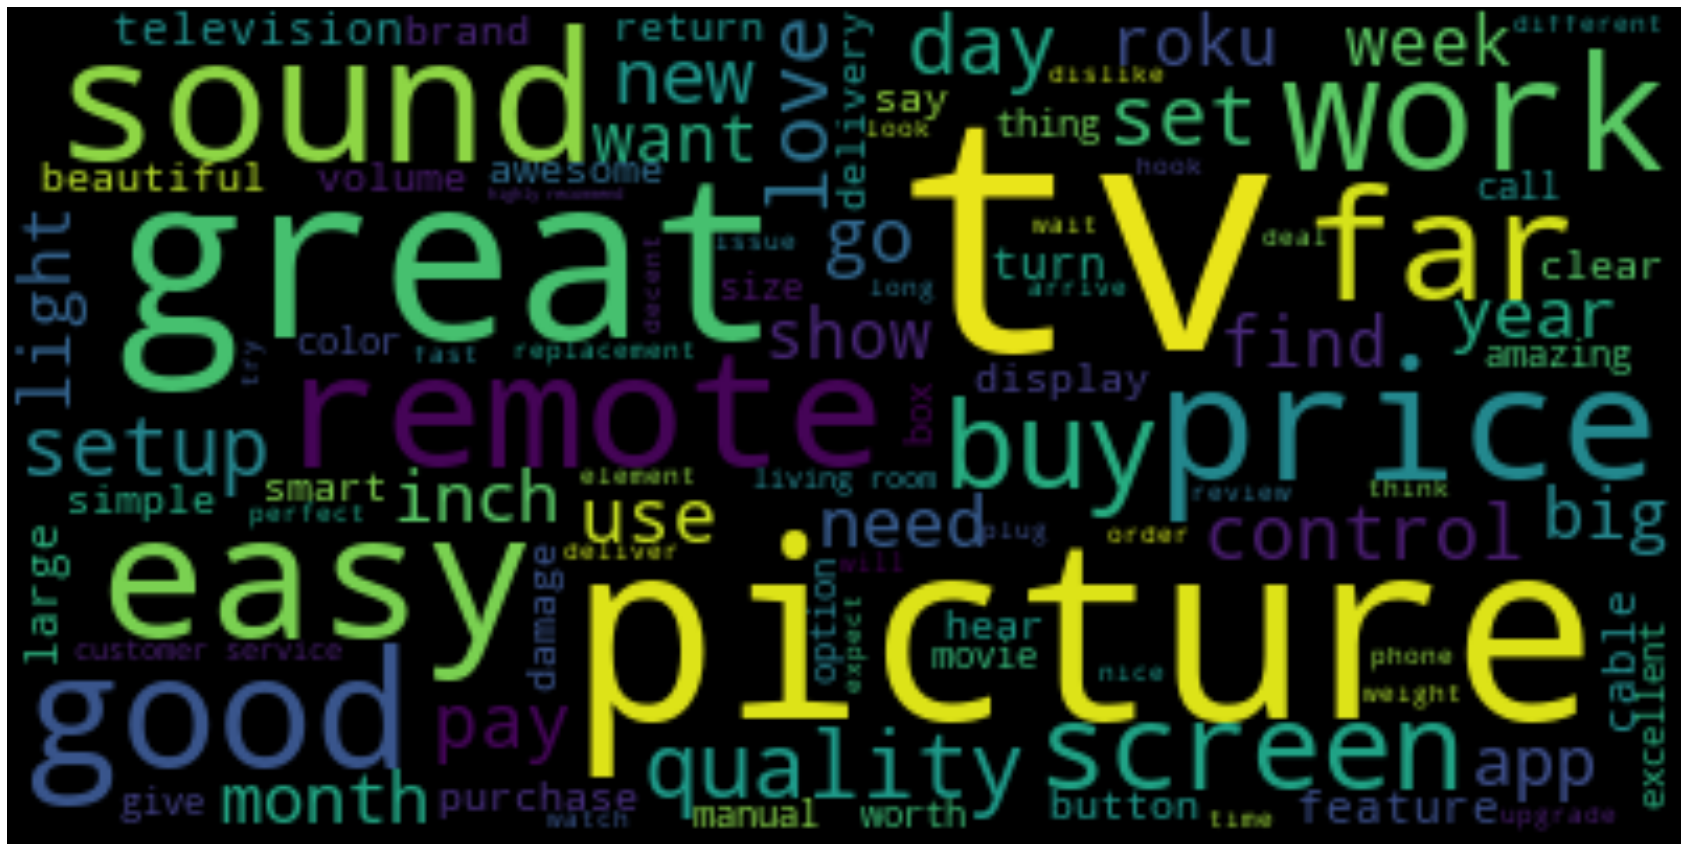

In [46]:
#Create a word cloud to visualize the frequency of words in the reviews for product id: 632565655 
#The bigger the word the higher the frequency of occurence in user reviews. 

p_new_df = pd.read_csv(processed_csv_file)
filt = p_new_df['Product id'] == int(products[0])
p_new_df = p_new_df[filt]
create_wordcloud(p_new_df)

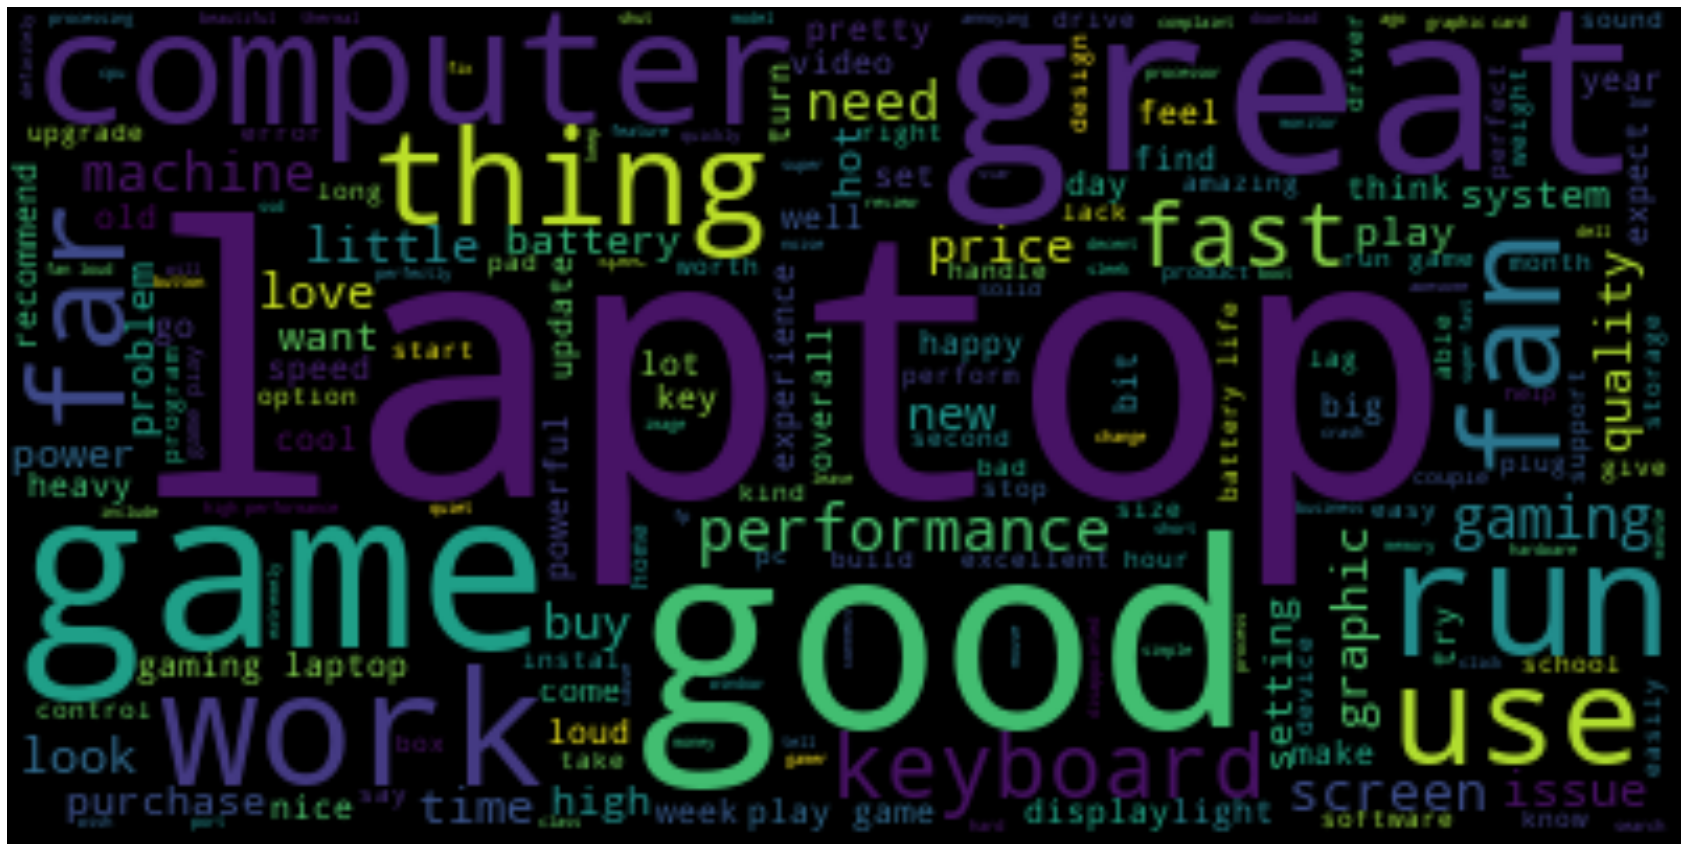

In [47]:
#Create a word cloud to visualize the frequency of words in the reviews for product id: 527724820 
#The bigger the word the higher the frequency of occurence in user reviews. 

p_new_df = pd.read_csv(processed_csv_file)
filt = p_new_df['Product id'] == int(products[1])
p_new_df = p_new_df[filt]
create_wordcloud(p_new_df)

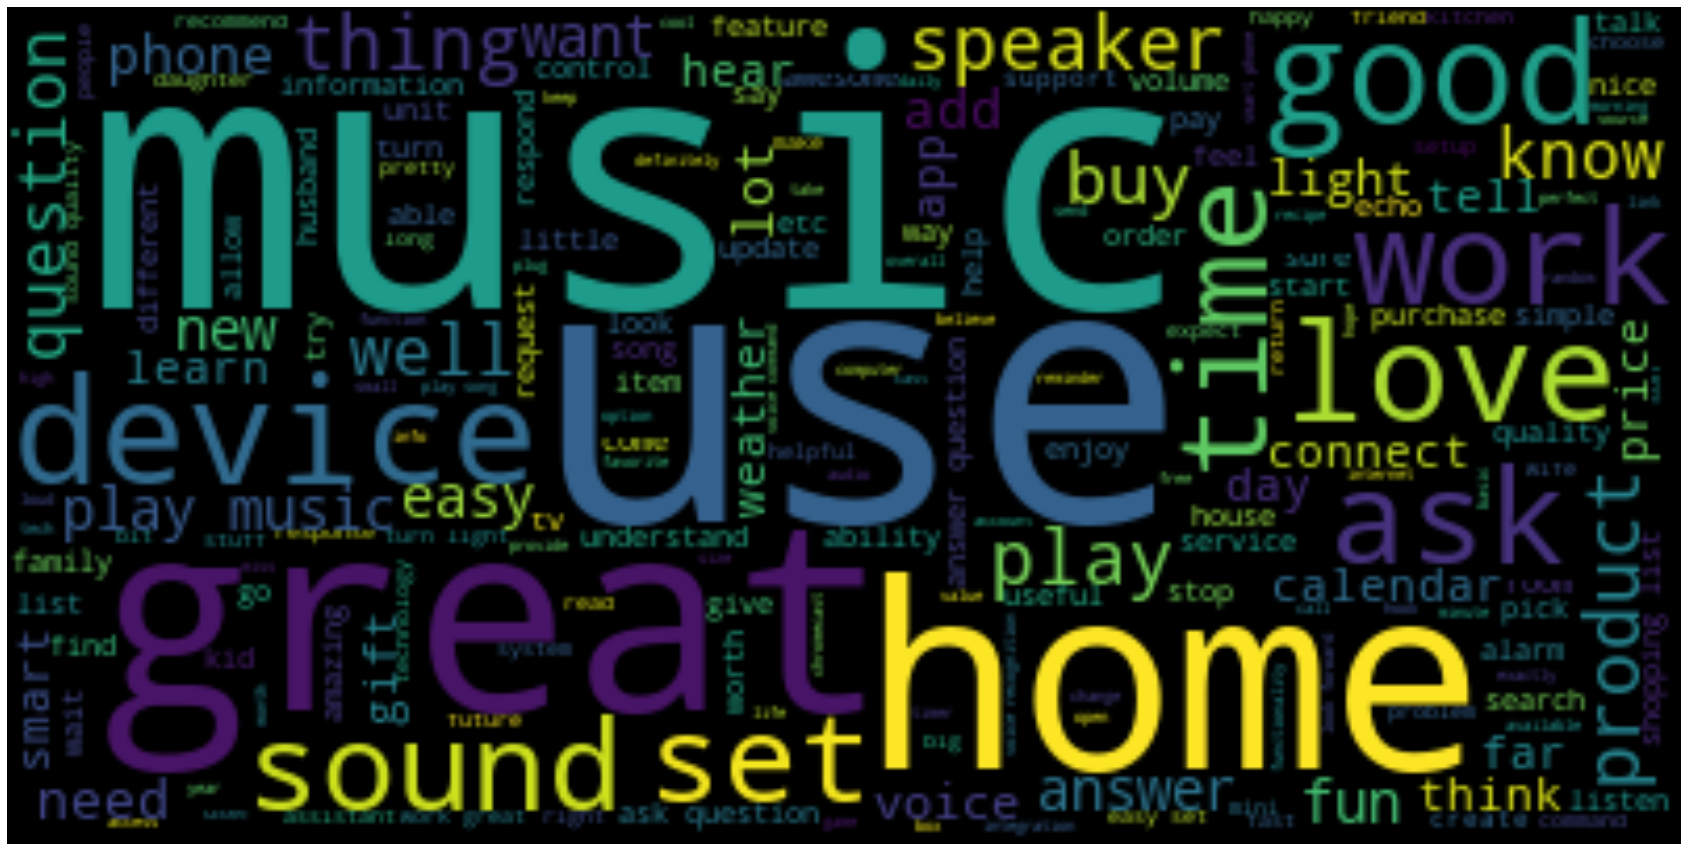

In [48]:
#Create a word cloud to visualize the frequency of words in the reviews for product id: 54742302 
#The bigger the word the higher the frequency of occurence in user reviews. 

p_new_df = pd.read_csv(processed_csv_file)
filt = p_new_df['Product id'] == int(products[2])
p_new_df = p_new_df[filt]
create_wordcloud(p_new_df)

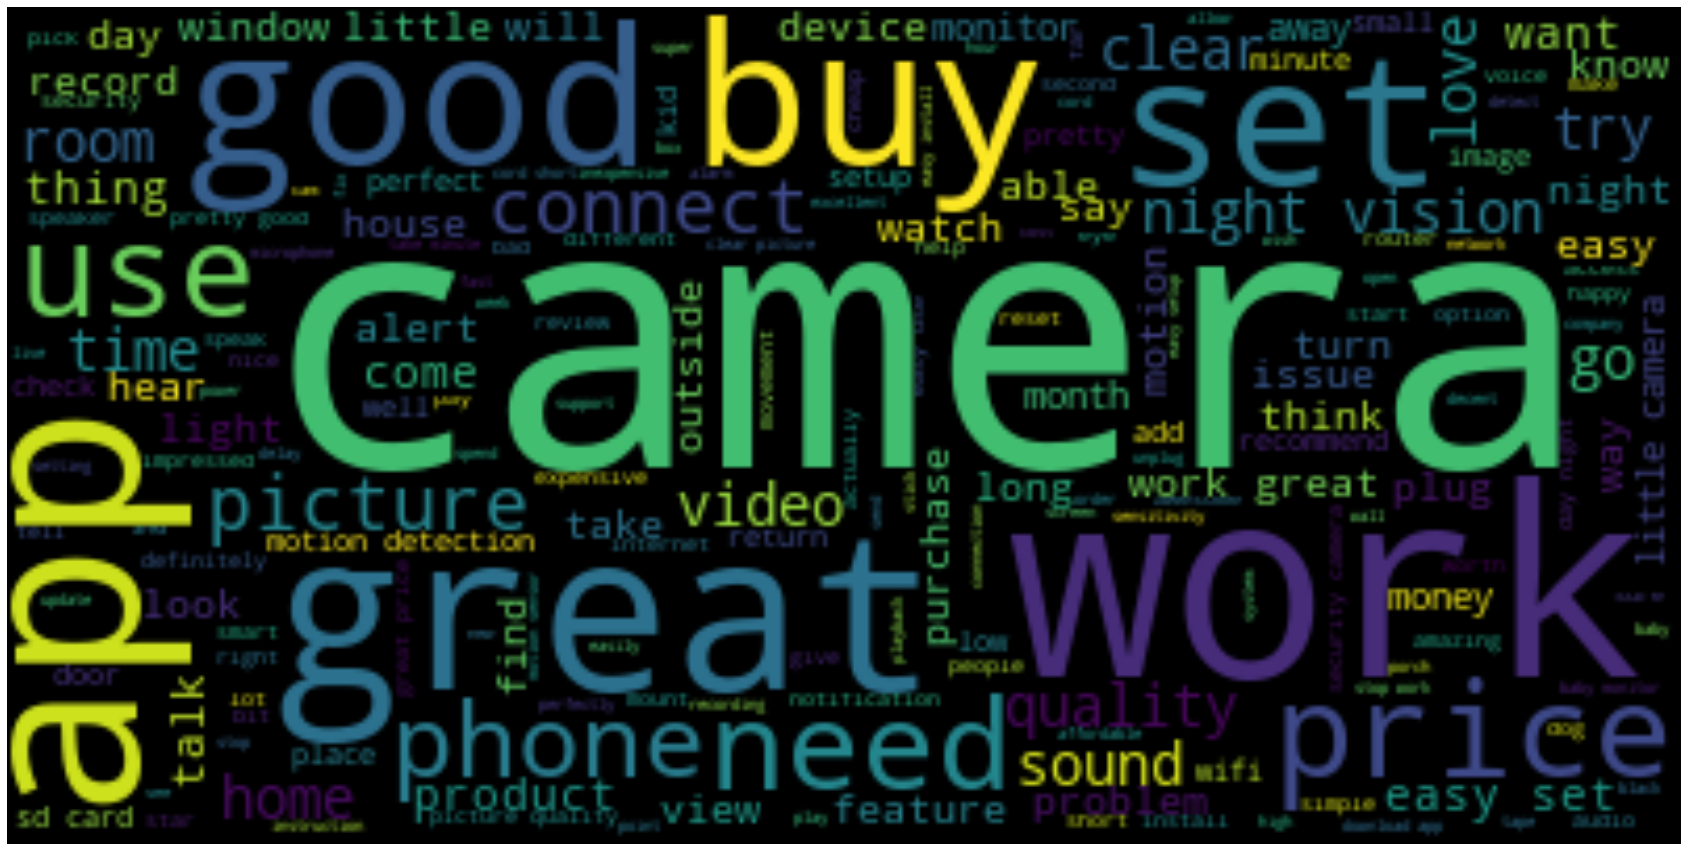

In [49]:
#Create a word cloud to visualize the frequency of words in the reviews for product id: 835969619 
#The bigger the word the higher the frequency of occurence in user reviews. 

p_new_df = pd.read_csv(processed_csv_file)
filt = p_new_df['Product id'] == int(products[3])
p_new_df = p_new_df[filt]
create_wordcloud(p_new_df)

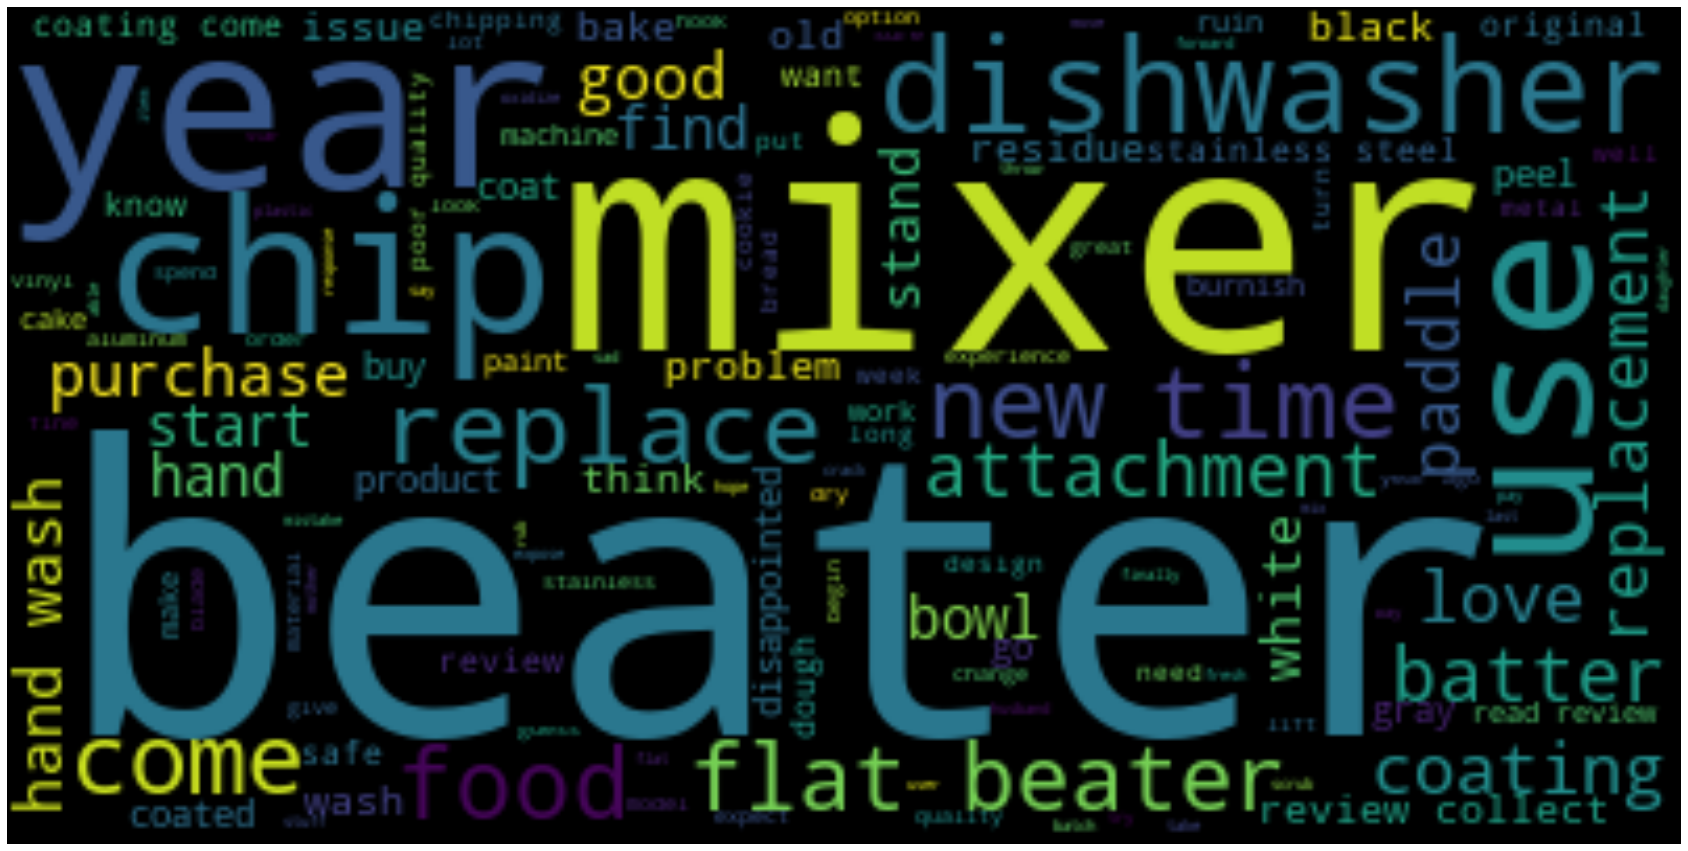

In [50]:
#Create a word cloud to visualize the frequency of words in the reviews for product id: 835969619 
#The bigger the word the higher the frequency of occurence in user reviews. 

p_new_df = pd.read_csv(processed_csv_file)
filt = p_new_df['Product id'] == int(products[4])
p_new_df = p_new_df[filt]
create_wordcloud(p_new_df)

### Identifying Percentage of Positive, Negative and Neutral reviews

Text(0, 0.5, 'Percentage(%)')

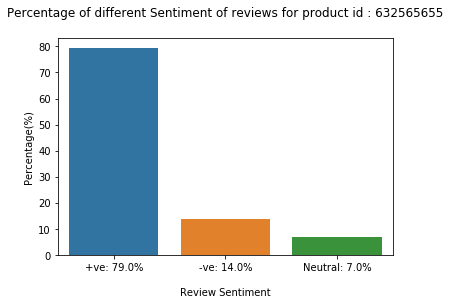

In [51]:
p_new_df = pd.read_csv(processed_csv_file)
filt1 = p_new_df['Product id'] == int(products[0])
filt2 = p_new_df['SIntensity'] < -0.05
filt3 = p_new_df['SIntensity'] > 0.05
filt4 = (p_new_df['SIntensity'] > -0.05) & (p_new_df['SIntensity'] < 0.05)

neg_df = p_new_df[filt1 & filt2]
pos_df = p_new_df[filt1 & filt3]
neu_df = p_new_df[filt1 & filt4]

neg_cnt = neg_df['SIntensity'].count()
pos_cnt = pos_df['SIntensity'].count()
neu_cnt = neu_df['SIntensity'].count()

total=neg_cnt+pos_cnt+neu_cnt
neg_percentage=neg_cnt/total*100
pos_percentage=pos_cnt/total*100
nue_percentage=neu_cnt/total*100
count = [pos_percentage,neg_percentage,nue_percentage]

senti = ["+ve: "+str(round(pos_percentage))+"%","-ve: "+str(round(neg_percentage))+"%","Neutral: "+str(round(nue_percentage))+"%"]

sb.barplot(senti,count)
plt.title("Percentage of different Sentiment of reviews for product id : "+products[0]+"\n")
plt.xlabel('\nReview Sentiment')
plt.ylabel('Percentage(%)')

Text(0, 0.5, 'Percentage(%)')

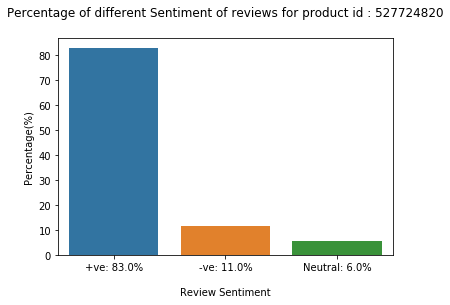

In [52]:
p_new_df = pd.read_csv(processed_csv_file)
filt1 = p_new_df['Product id'] == int(products[1])
filt2 = p_new_df['SIntensity'] < -0.05
filt3 = p_new_df['SIntensity'] > 0.05
filt4 = (p_new_df['SIntensity'] > -0.05) & (p_new_df['SIntensity'] < 0.05)

neg_df = p_new_df[filt1 & filt2]
pos_df = p_new_df[filt1 & filt3]
neu_df = p_new_df[filt1 & filt4]

neg_cnt = neg_df['SIntensity'].count()
pos_cnt = pos_df['SIntensity'].count()
neu_cnt = neu_df['SIntensity'].count()

total=neg_cnt+pos_cnt+neu_cnt
neg_percentage=neg_cnt/total*100
pos_percentage=pos_cnt/total*100
nue_percentage=neu_cnt/total*100
count = [pos_percentage,neg_percentage,nue_percentage]

senti = ["+ve: "+str(round(pos_percentage))+"%","-ve: "+str(round(neg_percentage))+"%","Neutral: "+str(round(nue_percentage))+"%"]

sb.barplot(senti,count)
plt.title("Percentage of different Sentiment of reviews for product id : "+products[1]+"\n")
plt.xlabel('\nReview Sentiment')
plt.ylabel('Percentage(%)')

Text(0, 0.5, 'Percentage(%)')

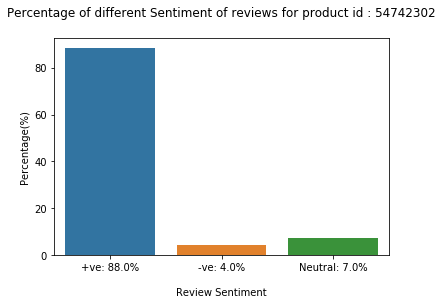

In [53]:
p_new_df = pd.read_csv(processed_csv_file)
filt1 = p_new_df['Product id'] == int(products[2])
filt2 = p_new_df['SIntensity'] < -0.05
filt3 = p_new_df['SIntensity'] > 0.05
filt4 = (p_new_df['SIntensity'] > -0.05) & (p_new_df['SIntensity'] < 0.05)

neg_df = p_new_df[filt1 & filt2]
pos_df = p_new_df[filt1 & filt3]
neu_df = p_new_df[filt1 & filt4]

neg_cnt = neg_df['SIntensity'].count()
pos_cnt = pos_df['SIntensity'].count()
neu_cnt = neu_df['SIntensity'].count()

total=neg_cnt+pos_cnt+neu_cnt
neg_percentage=neg_cnt/total*100
pos_percentage=pos_cnt/total*100
nue_percentage=neu_cnt/total*100
count = [pos_percentage,neg_percentage,nue_percentage]

senti = ["+ve: "+str(round(pos_percentage))+"%","-ve: "+str(round(neg_percentage))+"%","Neutral: "+str(round(nue_percentage))+"%"]

sb.barplot(senti,count)
plt.title("Percentage of different Sentiment of reviews for product id : "+products[2]+"\n")
plt.xlabel('\nReview Sentiment')
plt.ylabel('Percentage(%)')

Text(0, 0.5, 'Percentage(%)')

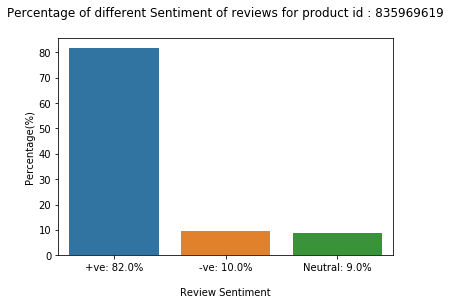

In [54]:
p_new_df = pd.read_csv(processed_csv_file)
filt1 = p_new_df['Product id'] == int(products[3])
filt2 = p_new_df['SIntensity'] < -0.05
filt3 = p_new_df['SIntensity'] > 0.05
filt4 = (p_new_df['SIntensity'] > -0.05) & (p_new_df['SIntensity'] < 0.05)

neg_df = p_new_df[filt1 & filt2]
pos_df = p_new_df[filt1 & filt3]
neu_df = p_new_df[filt1 & filt4]

neg_cnt = neg_df['SIntensity'].count()
pos_cnt = pos_df['SIntensity'].count()
neu_cnt = neu_df['SIntensity'].count()

total=neg_cnt+pos_cnt+neu_cnt
neg_percentage=neg_cnt/total*100
pos_percentage=pos_cnt/total*100
nue_percentage=neu_cnt/total*100
count = [pos_percentage,neg_percentage,nue_percentage]

senti = ["+ve: "+str(round(pos_percentage))+"%","-ve: "+str(round(neg_percentage))+"%","Neutral: "+str(round(nue_percentage))+"%"]

sb.barplot(senti,count)
plt.title("Percentage of different Sentiment of reviews for product id : "+products[3]+"\n")
plt.xlabel('\nReview Sentiment')
plt.ylabel('Percentage(%)')

Text(0, 0.5, 'Percentage(%)')

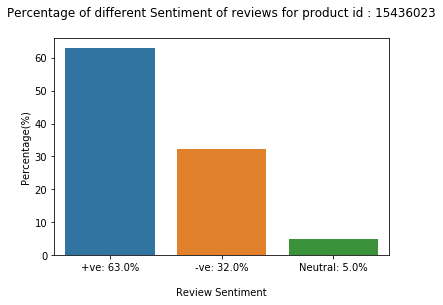

In [55]:
p_new_df = pd.read_csv(processed_csv_file)
filt1 = p_new_df['Product id'] == int(products[4])
filt2 = p_new_df['SIntensity'] < -0.05
filt3 = p_new_df['SIntensity'] > 0.05
filt4 = (p_new_df['SIntensity'] > -0.05) & (p_new_df['SIntensity'] < 0.05)

neg_df = p_new_df[filt1 & filt2]
pos_df = p_new_df[filt1 & filt3]
neu_df = p_new_df[filt1 & filt4]

neg_cnt = neg_df['SIntensity'].count()
pos_cnt = pos_df['SIntensity'].count()
neu_cnt = neu_df['SIntensity'].count()

total=neg_cnt+pos_cnt+neu_cnt
neg_percentage=neg_cnt/total*100
pos_percentage=pos_cnt/total*100
nue_percentage=neu_cnt/total*100
count = [pos_percentage,neg_percentage,nue_percentage]

senti = ["+ve: "+str(round(pos_percentage))+"%","-ve: "+str(round(neg_percentage))+"%","Neutral: "+str(round(nue_percentage))+"%"]

sb.barplot(senti,count)
plt.title("Percentage of different Sentiment of reviews for product id : "+products[4]+"\n")
plt.xlabel('\nReview Sentiment')
plt.ylabel('Percentage(%)')